# Import packages

In [15]:
import tensorflow as tf
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf

from pandas_datareader import data as wb
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler 

%matplotlib inline

# Set figure parameters
plt.rcParams['figure.figsize'] = [10, 7.5]

# Input data

[*********************100%%**********************]  1 of 1 completed


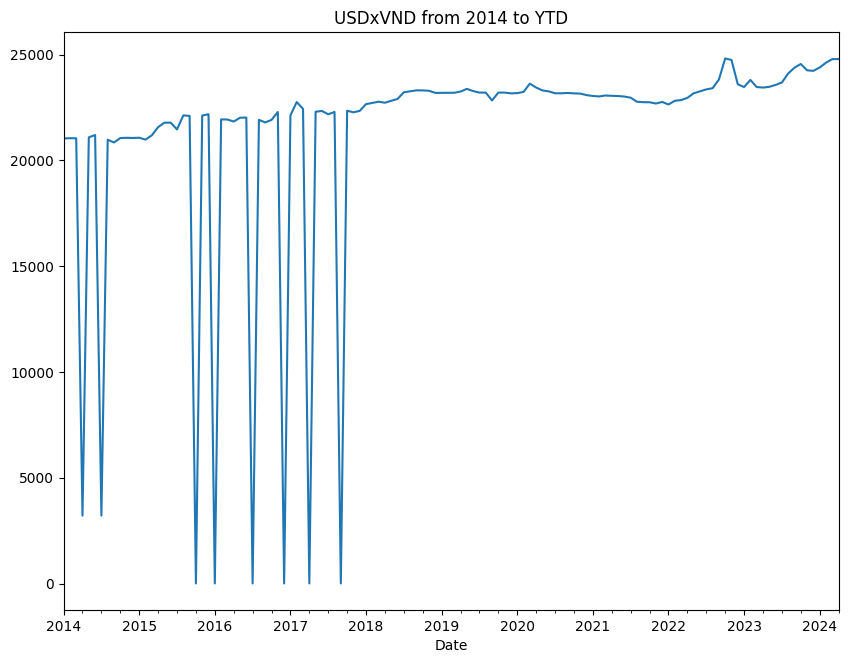

Total data: 10 years


In [16]:
yf.pdr_override()

data = wb.get_data_yahoo('VND=x', start = '2014-01-01', end = '2024-12-31', interval = '1mo')

# Plot
data['Adj Close'].plot()
plt.title("USDxVND from 2014 to YTD")
plt.show()

# Summary statistics
df = pd.DataFrame(data['Adj Close']) 

diff = df.index.values[-1] - df.index.values[0]
months = diff.astype('timedelta64[M]')
years = int(months/12)
print("Total data: %d years" %years)

# Univariate RNN

In [79]:
df.values[1:].reshape(-1,1)

array([[2.10500000e+04],
       [2.10480000e+04],
       [3.21000000e+03],
       [2.10900000e+04],
       [2.12010000e+04],
       [3.21100000e+03],
       [2.09790000e+04],
       [2.08500000e+04],
       [2.10580000e+04],
       [2.10700000e+04],
       [2.10620000e+04],
       [2.10740000e+04],
       [2.09840000e+04],
       [2.11860000e+04],
       [2.15750000e+04],
       [2.17850000e+04],
       [2.17850000e+04],
       [2.14650000e+04],
       [2.21290000e+04],
       [2.21050000e+04],
       [2.27272701e+00],
       [2.21210000e+04],
       [2.21850000e+04],
       [2.27790403e+00],
       [2.19410000e+04],
       [2.19340000e+04],
       [2.18390000e+04],
       [2.20200000e+04],
       [2.20280000e+04],
       [2.25225210e+00],
       [2.19170000e+04],
       [2.17970000e+04],
       [2.19160000e+04],
       [2.22910000e+04],
       [2.32558107e+00],
       [2.21320000e+04],
       [2.27600000e+04],
       [2.24350000e+04],
       [2.32018590e+00],
       [2.23040000e+04],


In [68]:
# Flatten matrix
npa = df.values[1:].reshape(-1,1)
print(len(npa))

# Scale data
scale = MinMaxScaler(feature_range=(0,1))
npa = scale.fit_transform(npa)
print(len(npa))

123
123


In [69]:
samples = 10
steps = 1
x = []
y = []

for i in range(npa.shape[0] - samples):
    x.append(npa[i:i+samples]) # independent samples
    y.append(npa[i+samples][0]) # dependent samples
print('Training Data: Length is', len(x[0:1][0]),':',x[0:1])
print('Testing Data: Length is', len(y[0:1]),':',y[0:1])

Training Data: Length is 10 : [array([[0.84809258],
       [0.84801199],
       [0.12925217],
       [0.84970433],
       [0.85417694],
       [0.12929246],
       [0.84523173],
       [0.84003383],
       [0.84841493],
       [0.84889846]])]
Testing Data: Length is 1 : [0.8485761061731205]


In [70]:
# Reshape data
x = np.array(x)
y = np.array(y)

# Split data
threshold = round(0.9*x.shape[0])
print('threshold is', threshold)


threshold is 102


In [71]:
# Building RNN model

model = keras.Sequential()
model.add(layers.SimpleRNN(3, activation='tanh', use_bias = True, input_shape=(x.shape[1],x.shape[2])))

model.add(layers.Dropout(rate=0.2))

model.add(layers.Dense(1))

model.compile(loss='mean_squared_error', optimizer = 'adam')

model.summary()

C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_6 (SimpleRNN)        │ (None, 3)              │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19 (76.00 B)

 Trainable params: 19 (76.00 B)

 Non-trainable params: 0 (0.00 B)

In [72]:
# Fitting the data
history = model.fit(x[:threshold],y[:threshold],shuffle=False,epochs=100,batch_size=32,validation_split=0.2,verbose=1)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - loss: 0.8783 - val_loss: 0.8825
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6748 - val_loss: 0.6239
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5026 - val_loss: 0.4157
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3574 - val_loss: 0.2598
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2644 - val_loss: 0.1509
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2111 - val_loss: 0.0795
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1336 - val_loss: 0.0376
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1315 - val_loss: 0.0156
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1679 - val_loss: 0.0059
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1411 - val_loss: 0.0022
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1554 - val_loss: 0.0013
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1696 - val_l

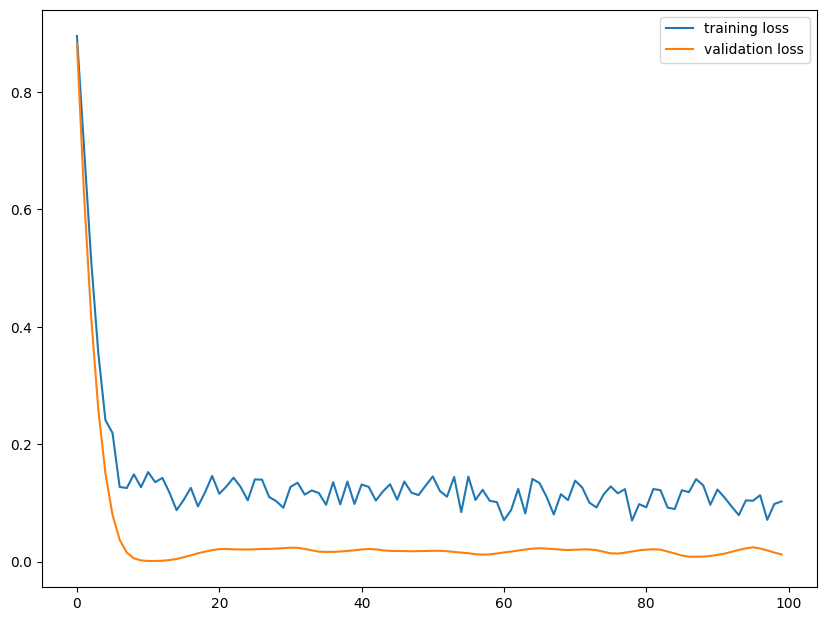

In [73]:
# Plotting the loss iteration
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()

If training loss >> validation loss, then underfit <br>
If training loss << validation loss, then overfit

## Multi-step forecast

In [74]:
true_y = y[threshold:]
pred_y = []
latest_input = x[threshold-1:threshold]
for i in range(y.shape[0] - round(y.shape[0]*0.9)):
    p = model.predict(latest_input.reshape(1,x.shape[1],1))[0,0]

    pred_y.append(p)
    latest_input = np.append(x[threshold][1:],p)
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


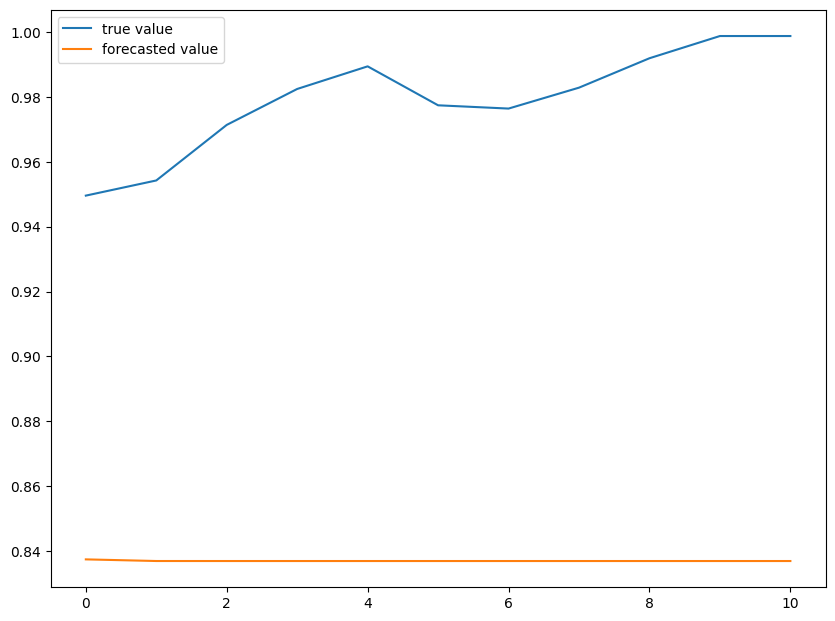

In [75]:
plt.plot(true_y,label='true value')
plt.plot(pred_y, label = 'forecasted value')
plt.legend()